# Make tensors (time, location, age; count)

In [76]:
import datetime
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import tqdm
ROOTPATH = "../raw/"
OUTPATH = "../dat/"
os.makedirs(OUTPATH, exist_ok=True)
warnings.filterwarnings("ignore")

In [5]:
def load_data(date_index):
    return pd.read_csv(ROOTPATH + date_index + "-citibike-tripdata.csv")

In [32]:
def generate_station_data(start="2017-01", end="2020-12", outpath=None):
    """ Extract the consisten station information
        between 'start' and 'end'.
    """

    df_station_list = []

    for date_index in tqdm.tqdm(pd.date_range(start="2016-01", end="2020-12", freq='m')):

        # original trip data
        df = load_data(date_index.strftime("%Y%m"))

        # ensure the consistency of column names
        df.columns = df.columns.str.replace(" ", "")
        df.columns = df.columns.str.lower()

        # start station data
        df_stt = df[[
            "startstationid",
            "startstationname",
            "startstationlatitude",
            "startstationlongitude"
        ]]

        # end station data
        df_end = df[[
            "endstationid",
            "endstationname",
            "endstationlatitude",
            "endstationlongitude"
        ]]

        # rename columns
        df_stt.columns = df_stt.columns.str.replace("start", "")
        df_end.columns = df_end.columns.str.replace("end", "")

        # get unique station data
        df = pd.concat([df_stt, df_end])
        df = df.drop_duplicates(subset=["stationid"])

        df_station_list.append(df.copy())

    # extract full station data
    station_data = pd.concat(df_station_list)
    station_data = station_data.drop_duplicates(subset=["stationid"])
    station_data = station_data.dropna(how="any")
    station_data = station_data.reset_index(drop=True)  # remove unused index
    station_data = station_data.reset_index(drop=True)  # remove unused index
    station_data = station_data.reset_index()  # save unique id from zero
    station_data = station_data.astype({"stationid": int})

    if outpath is not None:
        station_data.to_csv(
            os.path.join(outpath, "station_data_{}_{}.csv".format(start, end)),
            index=False)

    return station_data

In [30]:
station_data = generate_station_data(start="2017-01", end="2020-12", outpath=OUTPATH)

100%|██████████| 59/59 [02:39<00:00,  2.70s/it]


<AxesSubplot:>

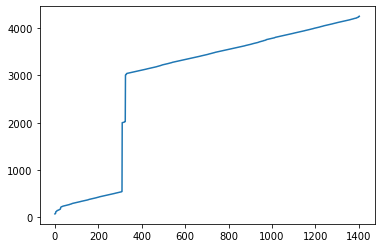

In [33]:
station_data.reset_index(drop=True).reset_index()
station_data.stationid.sort_values().reset_index(drop=True).plot()

In [60]:
def process(df):
    """ Load $ preprocess the original trip data """
    # Cleaning
    df = df.dropna(how="any")
    df.columns = df.columns.str.replace(" ", "")
    df.columns = df.columns.str.lower()
    df = df.query("usertype=='Subscriber'")
    df["userage"] = 2013 - df["birthyear"]
    df = df[["starttime", "startstationid", "endstationid", "userage"]]
    df = df.reset_index(drop=True)

    # Cast
    df = df.astype({
        "startstationid": int,
        "endstationid": int,
        "userage": int
    })
    
    return df

In [79]:
def save_dataset(start="2017-01", end="2020-12"):

    # get station data
    fn = OUTPATH + "station_data_{}_{}.csv".format(start, end)
    if os.path.isfile(fn):
        station_data = pd.read_csv(fn)
    else:
        station_data = generate_station_data(start, end, OUTPATH)

    dataset_path = OUTPATH + "station_age_{}_{}/".format(start, end)
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path)
    os.makedirs(dataset_path)

    # make monthly event series
    for date_index in pd.date_range(start=start, end=end, freq='m'):
        print(date_index)
        # data processing
        df = load_data(date_index.strftime("%Y%m"))
        df = process(df)
        # encode start station indices
        df = pd.merge(df, station_data[["index", "stationid"]],
                      how="left", left_on="startstationid", right_on="stationid")
        df = df.rename({"index": "start_station_dim"}, axis=1)
        del df["stationid"]
        # encode end station indices
        df = pd.merge(df, station_data[["index", "stationid"]],
                      how="left", left_on="endstationid", right_on="stationid")
        df = df.rename({"index": "end_station_dim"}, axis=1)
        del df["stationid"]
        # cleaning
        df = df.dropna(how="any")
        # save
        print(df.head())
        df.to_csv(dataset_path + "station_age_{}.csv".format(date_index.strftime("%Y%m")), index=False)

In [80]:
save_dataset(start="2017-01", end="2020-12")

    29   

   start_station_dim  end_station_dim  
0                245              447  
1                245              456  
2                245              405  
3                245              171  
4                245              167  
2018-07-31 00:00:00
                  starttime  startstationid  endstationid  userage  \
0  2018-07-01 00:33:51.2640              72          3236       32   
1  2018-07-01 02:06:54.0270              72           529       25   
2  2018-07-01 02:09:16.4640              72           453       31   
3  2018-07-01 02:55:04.5870              72           465       27   
4  2018-07-01 03:24:27.4350              72          3425       21   

   start_station_dim  end_station_dim  
0                245              466  
1                245              124  
2                245              294  
3                245              435  
4                245              539  
2018-08-31 00:00:00
                  starttime  startstationid  end